# Observational spatial analysis


In [1]:
%load_ext autoreload
%autoreload 2

import calendar
import matplotlib.pyplot as plt
import numpy as np
import os
import xarray as xr

from unseen import fileio, time_utils, eva
from acs_plotting_maps import cmap_dict, tick_dict  # NOQA

import spatial_plots

In [2]:
# Optional parameters
# (This cell is tagged "parameters")
dpi = 300
shapefile = None
shape_overlap = 0.1
alpha = 0.05
time_dim = "time"
lat_dim = "lat"
lon_dim = "lon"
similarity_test = "ks"
gev_relative_fit_test = "lrt"
time_agg = "maximum"

In [3]:
# Parameters
obs_name = "AGCD-CSIRO"
metric = "txx"
var = "tasmax"
reference_time_period = "1961-06-30 2023-06-30"
time_agg = "maximum"
covariate_base = 2025
gev_trend_period = "[1961, 2025]"
plot_dict = "dict(metric=\"TXx\", var=\"tasmax\", var_name=\"Temperature\", units=\"\xb0C\", units_label=\"Temperature [\xb0C]\", freq=\"YE-JUN\", cmap=cmap_dict[\"tasmax\"], cmap_anom=cmap_dict[\"anom\"], ticks=np.arange(22, 58 + 2, 2), ticks_anom=np.arange(-5, 5.5, 0.5), ticks_param_trend={\"location\": np.arange(-0.6, 0.61, 0.1), \"scale\": np.arange(-0.12, 0.122, 0.02)})"
fig_dir = "/g/data/xv83/unseen-projects/outputs/txx/figures"
obs_file = "/g/data/xv83/unseen-projects/outputs/txx/data/txx_AGCD-CSIRO_r05_1901-2024_annual-jul-to-jun_aus.nc"
gev_params_nonstationary_file = "/g/data/xv83/unseen-projects/outputs/txx/data/gev_params_nonstationary_bic_txx_AGCD-CSIRO_r05_1901-2024_annual-jul-to-jun_aus.nc"
gev_params_nonstationary_drop_max_file = "/g/data/xv83/unseen-projects/outputs/txx/data/gev_params_nonstationary_bic_txx_AGCD-CSIRO_r05_1901-2024_annual-jul-to-jun_aus_drop_max.nc"
shapefile = "/g/data/xv83/unseen-projects/outputs/txx/shapefiles/australia.shp"
shape_overlap = 0.1


In [4]:
# Required parameters
kwargs = locals()
assert "metric" in kwargs, "Must provide a metric name"
assert "var" in kwargs, "Must provide a variable name"
assert "obs_name" in kwargs, "Must provide a name"

if isinstance(reference_time_period, str):
    reference_time_period = list(reference_time_period.split(" "))

assert os.path.isfile(
    obs_file
), f"Must provide an observations data file (papermill option -p obs_file [filepath])"
assert os.path.isfile(
    gev_params_nonstationary_file
), f"Must provide a nonstationary GEV parameters file (papermill option -p gev_params_nonstationary_file [filepath])"
assert os.path.isfile(
    gev_params_nonstationary_drop_max_file
), f"Must provide a nonstationary GEV parameters file (papermill option -p gev_params_nonstationary_drop_max_file [filepath])"
assert (
    "covariate_base" in kwargs
), "Must provide a nonstationary GEV covariate base year"
assert (
    time_agg in spatial_plots.func_dict
), f"Invalid time aggregation method: {time_agg} (options: {list(spatial_plots.func_dict.keys())})"

# Format parameters passed as strings
assert (
    "gev_trend_period" in kwargs
), "Must provide a GEV trend period (e.g., '[1981, 2010]')"
if isinstance(gev_trend_period, str):
    # Convert string to list
    gev_trend_period = eval(gev_trend_period)
    print(f"gev_trend_period: {gev_trend_period}")

assert (
    "plot_dict" in kwargs
), "Must provide spatial plot dictionary of labels, ticks and colormaps"
if isinstance(plot_dict, str):
    # Convert string to dictionary and check for required keys
    plot_dict = eval(plot_dict)
    for key in [
        "metric",
        "var",
        "var_name",
        "units",
        "units_label",
        "freq",
        "cmap",
        "cmap_anom",
        "ticks",
        "ticks_anom",
        "ticks_param_trend",
    ]:
        assert key in plot_dict, f"Missing key: {key} in plot_dict"

gev_trend_period: [1961, 2025]


### Open dataset of metric in observational data

In [5]:
obs_ds = fileio.open_dataset(obs_file, shapefile=shapefile, shape_overlap=shape_overlap)
obs_ds

<xarray.Dataset> Size: 27MB
Dimensions:     (time: 113, lat: 66, lon: 82)
Coordinates:
  * lat         (lat) float64 528B -43.5 -43.0 -42.5 -42.0 ... -12.0 -11.5 -11.0
  * lon         (lon) float64 656B 113.0 113.5 114.0 114.5 ... 152.5 153.0 153.5
  * time        (time) object 904B 1911-06-30 00:00:00 ... 2023-06-30 00:00:00
    event_time  (time, lat, lon) <U10 24MB dask.array<chunksize=(113, 66, 82), meta=np.ndarray>
Data variables:
    tasmax      (time, lat, lon) float32 2MB dask.array<chunksize=(113, 66, 82), meta=np.ndarray>
Attributes: (12/34)
    CDI:                           Climate Data Interface version ?? (http://...
    history:                       Tue Sep 10 14:56:46 2024: /g/data/xv83/as3...
    institution:                   Australian Bureau of Meteorology, GPO Box ...
    Conventions:                   CF-1.6
    geospatial_lat_min:            -44.525
    geospatial_lat_max:            -9.975
    ...                            ...
    licence:                       Copyright for any data supplied by the Bur...
    id:                            Australian Gridded Climate Data (AGCD)
    summary:                       The daily maximum temperature station data...
    naming_authority:              au.gov.bom
    CDO:                           Climate Data Operators version 1.7.0 (http...
    regrid_method:                 conservative

In [6]:
# Select reference time period (defined in metric config file)
if reference_time_period is not None:
    obs_ds = time_utils.select_time_period(obs_ds, reference_time_period)
obs_ds = obs_ds.dropna("time", how="all")
obs_ds

<xarray.Dataset> Size: 15MB
Dimensions:     (time: 63, lat: 66, lon: 82)
Coordinates:
  * lat         (lat) float64 528B -43.5 -43.0 -42.5 -42.0 ... -12.0 -11.5 -11.0
  * lon         (lon) float64 656B 113.0 113.5 114.0 114.5 ... 152.5 153.0 153.5
  * time        (time) object 504B 1961-06-30 00:00:00 ... 2023-06-30 00:00:00
    event_time  (time, lat, lon) <U10 14MB dask.array<chunksize=(63, 66, 82), meta=np.ndarray>
Data variables:
    tasmax      (time, lat, lon) float32 1MB dask.array<chunksize=(63, 66, 82), meta=np.ndarray>
Attributes: (12/34)
    CDI:                           Climate Data Interface version ?? (http://...
    history:                       Tue Sep 10 14:56:46 2024: /g/data/xv83/as3...
    institution:                   Australian Bureau of Meteorology, GPO Box ...
    Conventions:                   CF-1.6
    geospatial_lat_min:            -44.525
    geospatial_lat_max:            -9.975
    ...                            ...
    licence:                       Copyright for any data supplied by the Bur...
    id:                            Australian Gridded Climate Data (AGCD)
    summary:                       The daily maximum temperature station data...
    naming_authority:              au.gov.bom
    CDO:                           Climate Data Operators version 1.7.0 (http...
    regrid_method:                 conservative

In [7]:
# Convert event time strings to cftime objects
event_times = np.vectorize(time_utils.str_to_cftime)(
    obs_ds.event_time, obs_ds.time.dt.calendar
)
obs_ds["event_time"] = (obs_ds.event_time.dims, event_times)
obs_ds

<xarray.Dataset> Size: 4MB
Dimensions:     (time: 63, lat: 66, lon: 82)
Coordinates:
  * lat         (lat) float64 528B -43.5 -43.0 -42.5 -42.0 ... -12.0 -11.5 -11.0
  * lon         (lon) float64 656B 113.0 113.5 114.0 114.5 ... 152.5 153.0 153.5
  * time        (time) object 504B 1961-06-30 00:00:00 ... 2023-06-30 00:00:00
    event_time  (time, lat, lon) object 3MB 1961-04-01 00:00:00 ... 2023-02-0...
Data variables:
    tasmax      (time, lat, lon) float32 1MB dask.array<chunksize=(63, 66, 82), meta=np.ndarray>
Attributes: (12/34)
    CDI:                           Climate Data Interface version ?? (http://...
    history:                       Tue Sep 10 14:56:46 2024: /g/data/xv83/as3...
    institution:                   Australian Bureau of Meteorology, GPO Box ...
    Conventions:                   CF-1.6
    geospatial_lat_min:            -44.525
    geospatial_lat_max:            -9.975
    ...                            ...
    licence:                       Copyright for any data supplied by the Bur...
    id:                            Australian Gridded Climate Data (AGCD)
    summary:                       The daily maximum temperature station data...
    naming_authority:              au.gov.bom
    CDO:                           Climate Data Operators version 1.7.0 (http...
    regrid_method:                 conservative

## Spatial Maps

In [8]:
# Store plot related variables
info = spatial_plots.InfoSet(
    name=obs_name,
    obs_name=obs_name,
    fig_dir=fig_dir,
    file=obs_file,
    ds_obs=obs_ds,
    **plot_dict,
)

# Year when max/min event occured

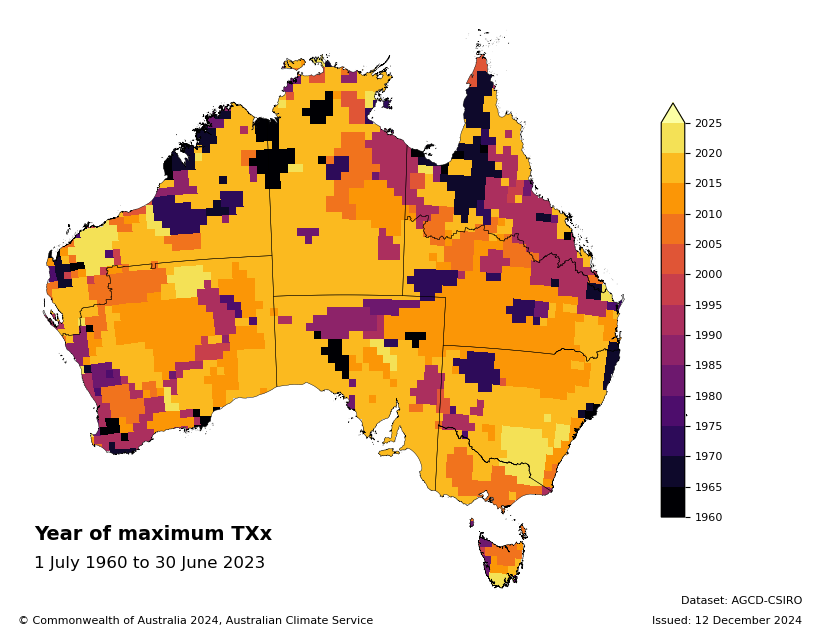

In [9]:
spatial_plots.plot_event_year(info, obs_ds, time_agg)

## Most common month for max/min event

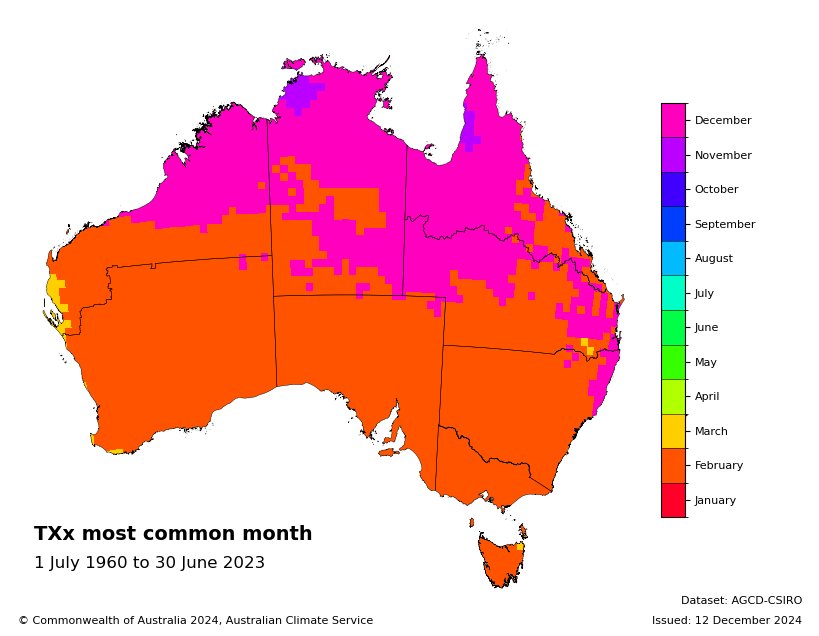

In [10]:
spatial_plots.plot_event_month_mode(info, obs_ds)

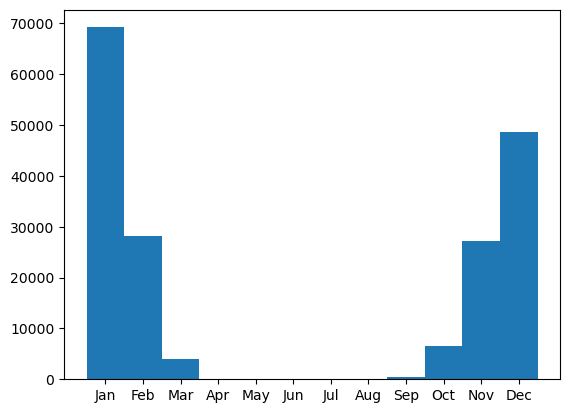

In [11]:
# Event month distribution (based on all grid points)
months = obs_ds.event_time.dt.month
months = xr.where(~np.isnan(obs_ds[var]), months, np.nan)
months.plot.hist(bins=np.arange(0.5, 13))
plt.xticks(np.arange(1, 13), [calendar.month_abbr[i] for i in range(1, 13)]);


## Map of metric median

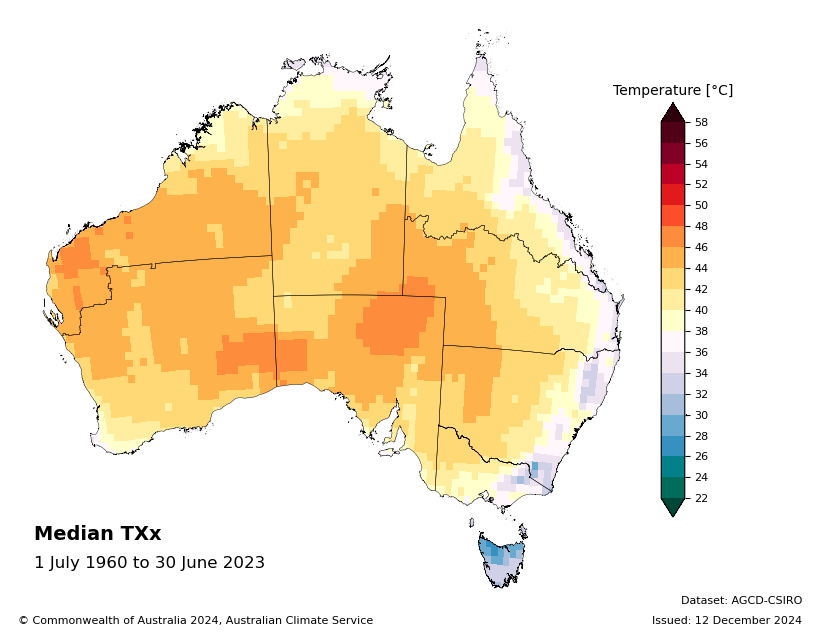

In [12]:
spatial_plots.plot_time_agg(info, obs_ds, "median")

# Map of metric maximum or minimum

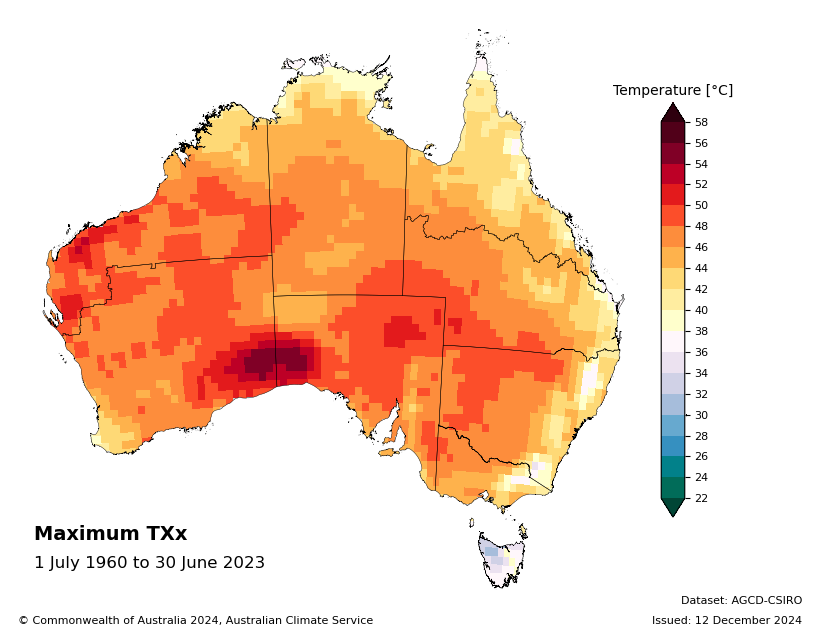

In [13]:
spatial_plots.plot_time_agg(info, obs_ds, time_agg)

# GEV analysis

In [14]:
# Load GEV parameters
covariate = obs_ds[time_dim].dt.year
times = xr.DataArray(gev_trend_period, dims="time")

In [15]:
dparams_ns = fileio.open_dataset(
    gev_params_nonstationary_file, shapefile=shapefile, shape_overlap=shape_overlap
)[var]

dparams_ns

<xarray.DataArray 'tasmax' (lat: 66, lon: 82, dparams: 5)> Size: 216kB
dask.array<getitem, shape=(66, 82, 5), dtype=float64, chunksize=(66, 82, 5), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 528B -43.5 -43.0 -42.5 -42.0 ... -12.0 -11.5 -11.0
  * lon      (lon) float64 656B 113.0 113.5 114.0 114.5 ... 152.5 153.0 153.5
  * dparams  (dparams) <U6 120B 'c' 'loc0' 'loc1' 'scale0' 'scale1'
Attributes:
    long_name:    Nonstationary genextreme parameters
    description:  Parameters of the nonstationary genextreme distribution
    method:       MLE
    estimator:    LMM
    scipy_dist:   genextreme
    units:

In [16]:
dparams_ns_drop_max = fileio.open_dataset(
    gev_params_nonstationary_drop_max_file,
    shapefile=shapefile,
    shape_overlap=shape_overlap,
)[var]

dparams_ns_drop_max

<xarray.DataArray 'tasmax' (lat: 66, lon: 82, dparams: 5)> Size: 216kB
dask.array<getitem, shape=(66, 82, 5), dtype=float64, chunksize=(66, 82, 5), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 528B -43.5 -43.0 -42.5 -42.0 ... -12.0 -11.5 -11.0
  * lon      (lon) float64 656B 113.0 113.5 114.0 114.5 ... 152.5 153.0 153.5
  * dparams  (dparams) <U6 120B 'c' 'loc0' 'loc1' 'scale0' 'scale1'
Attributes:
    long_name:    Nonstationary genextreme parameters
    description:  Parameters of the nonstationary genextreme distribution
    method:       MLE
    estimator:    LMM
    scipy_dist:   genextreme
    units:

# GEV parameters

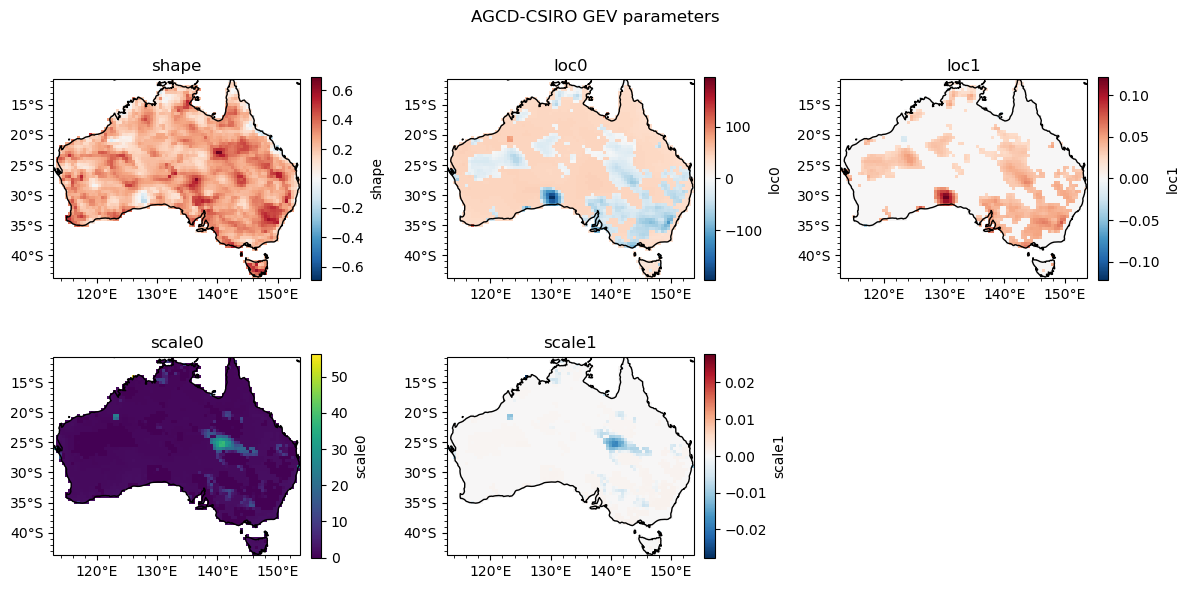

In [17]:
eva.spatial_plot_gev_parameters(
    dparams_ns,
    dataset_name=obs_name,
    outfile=f"{info.fig_dir}/gev_parameters_{info.filestem()}.png",
)

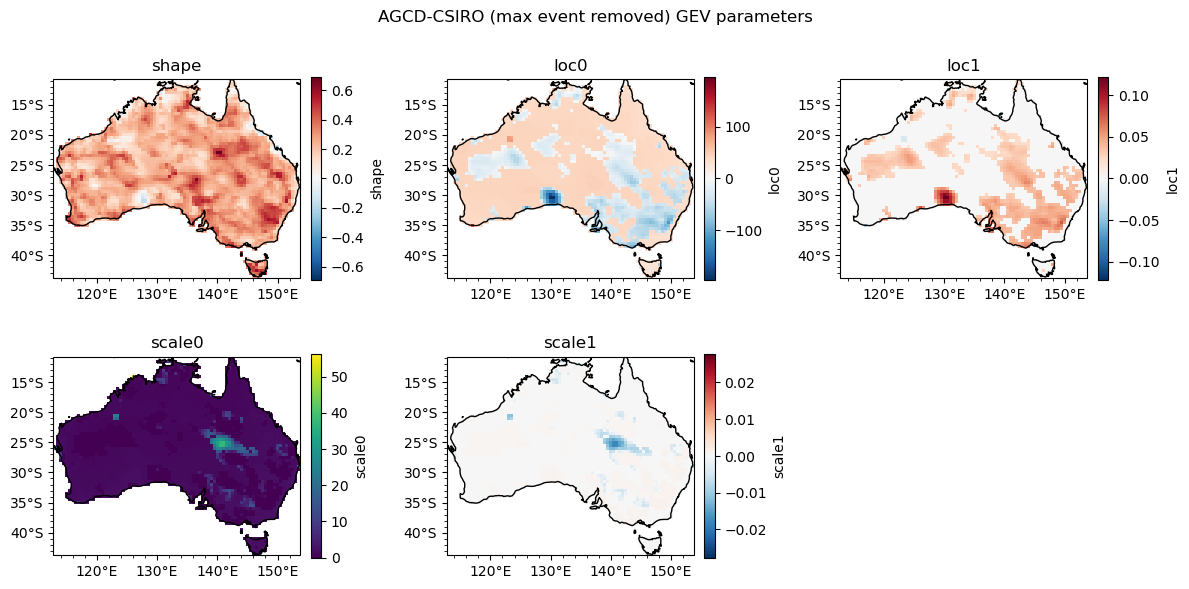

In [18]:
eva.spatial_plot_gev_parameters(
    dparams_ns_drop_max,
    dataset_name=obs_name + " (max event removed)",
    outfile=f"{info.fig_dir}/gev_parameters_{info.filestem()}_drop_max.png",
)

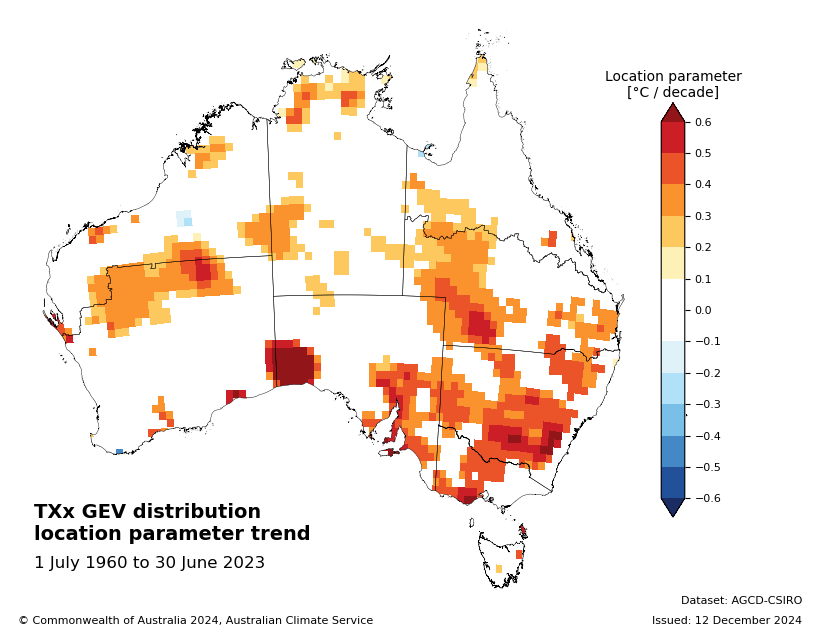

In [19]:
spatial_plots.plot_gev_param_trend(info, dparams_ns, "location")

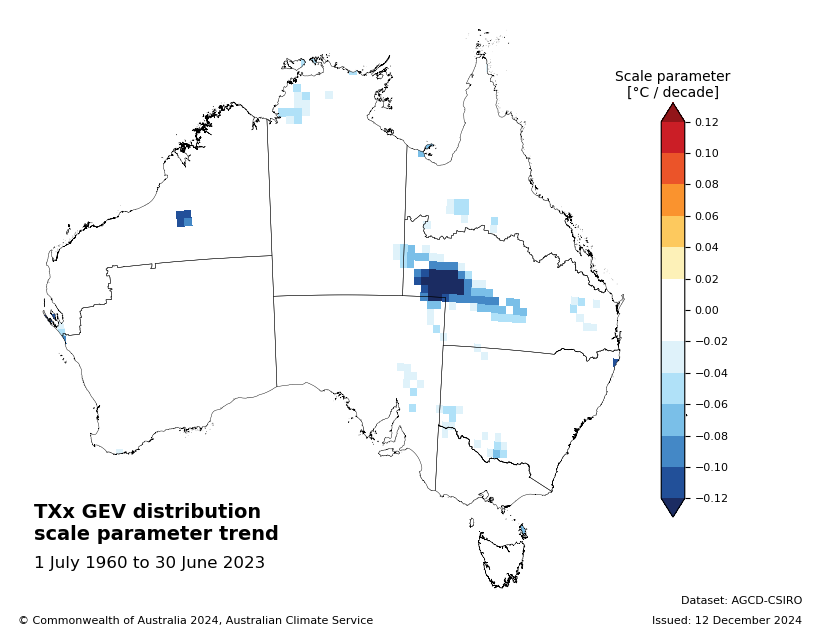

In [20]:
spatial_plots.plot_gev_param_trend(info, dparams_ns, "scale")

## Annual reccurence of observed max/min event

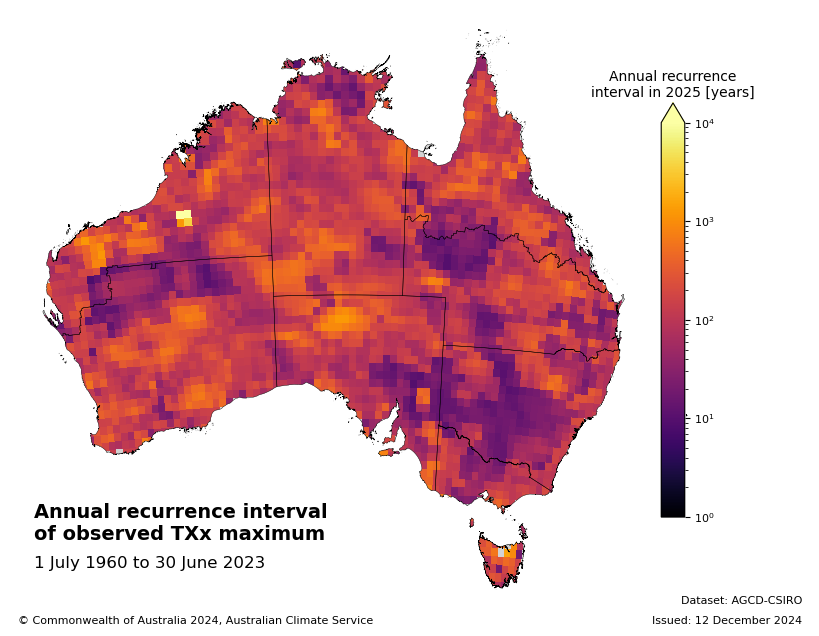

In [21]:
spatial_plots.plot_obs_ari(
    info,
    obs_ds,
    None,
    dparams_ns,
    covariate_base,
    time_agg=time_agg,
)

## Annual exceedance probability 
### GEV-based exceedance probability

In [22]:
# ARI: 10, 100, 1000 years (i.e., 10% AEP is equiv to a 1-in-10-year event)
aep_list = [10, 1, 0.1]

### Plot of 10% AEP (1-in-10-year event) using the non-stationary GEV (past year, current year and the change per decade)

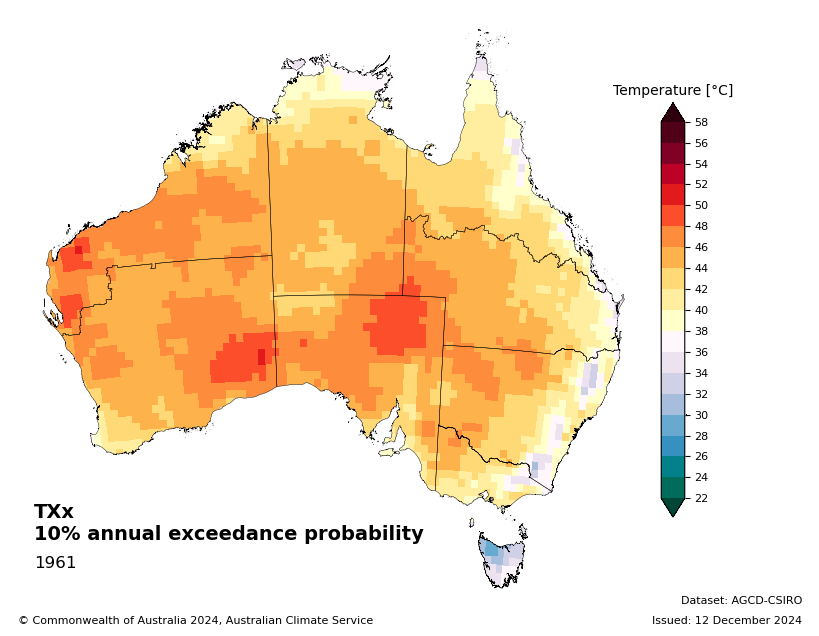

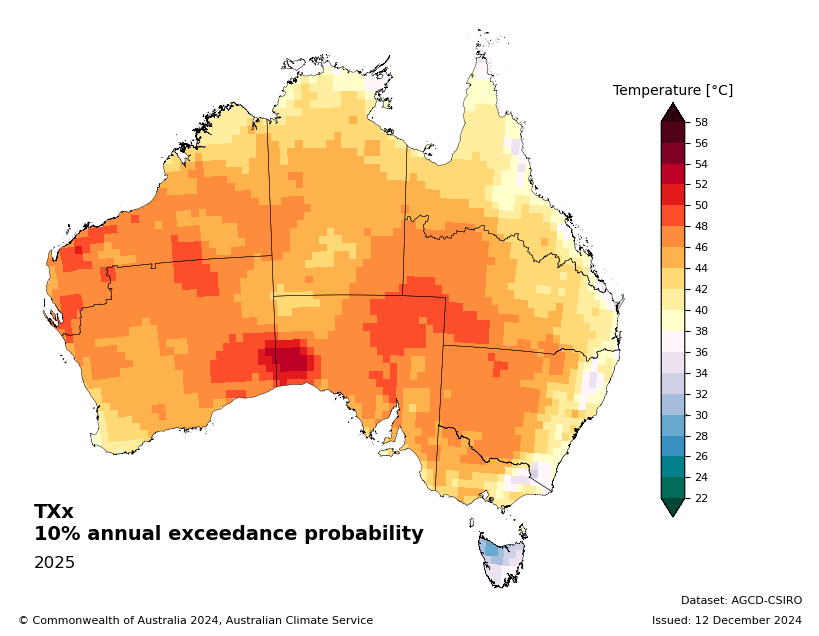

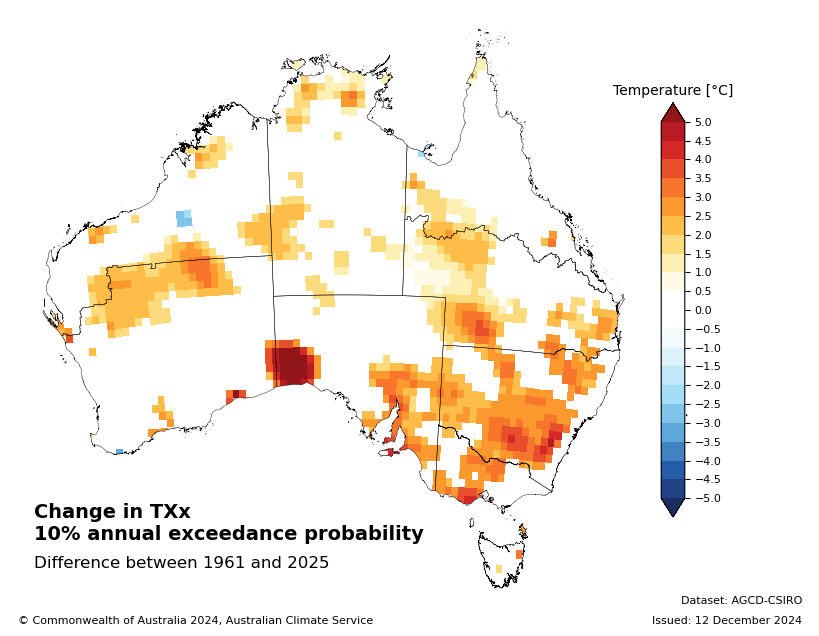

In [23]:
spatial_plots.plot_aep(
    info,
    dparams_ns,
    times,
    aep=aep_list[0],
)

### Plot of 1% AEP (1-in-100-year event) using the non-stationary GEV (past year, current year and the change per decade)

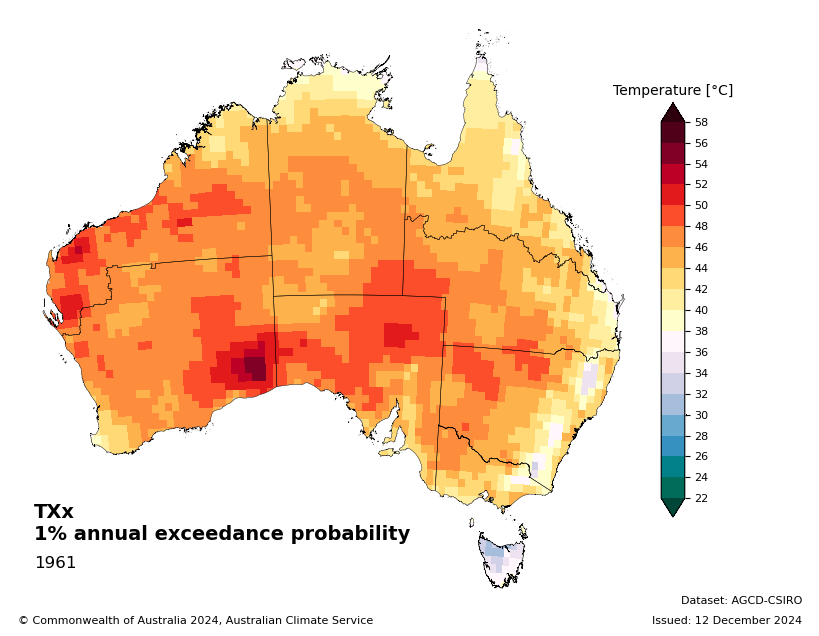

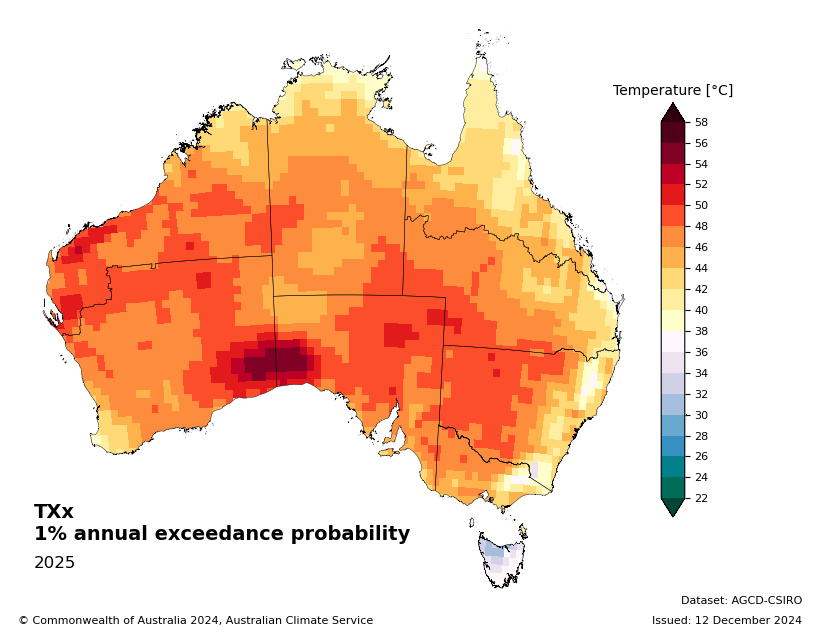

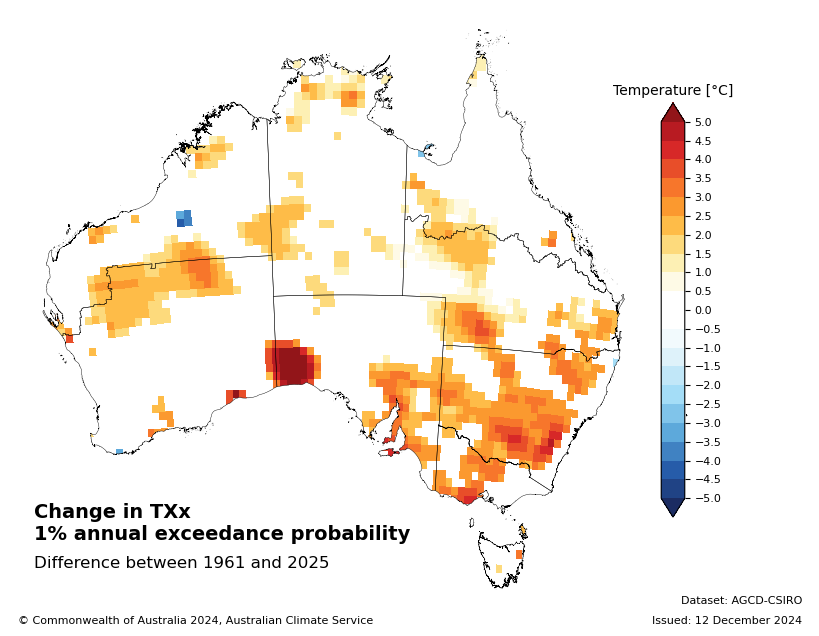

In [24]:
spatial_plots.plot_aep(
    info,
    dparams_ns,
    times,
    aep=aep_list[1],
)

### Plot of 0.1% AEP (1-in-1000-year event) using the non-stationary GEV (first year, last year and difference)

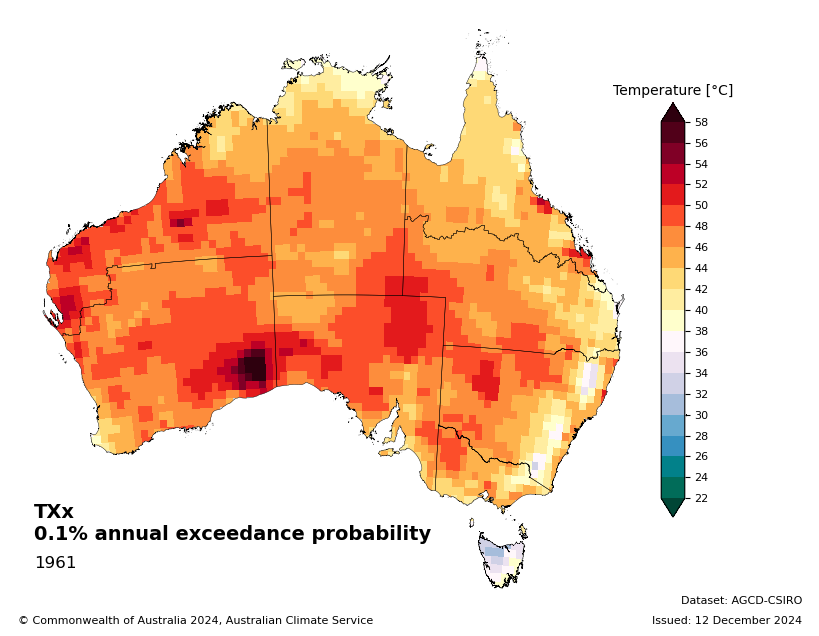

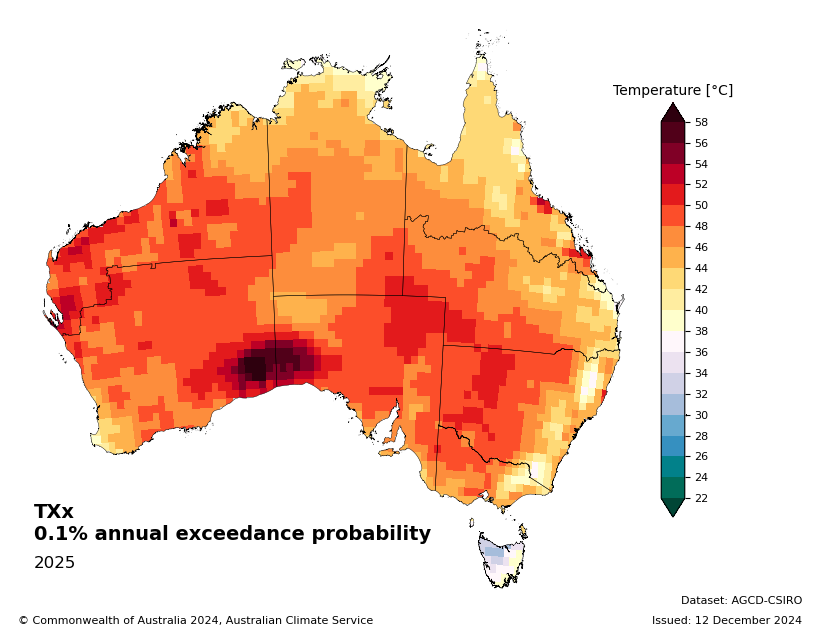

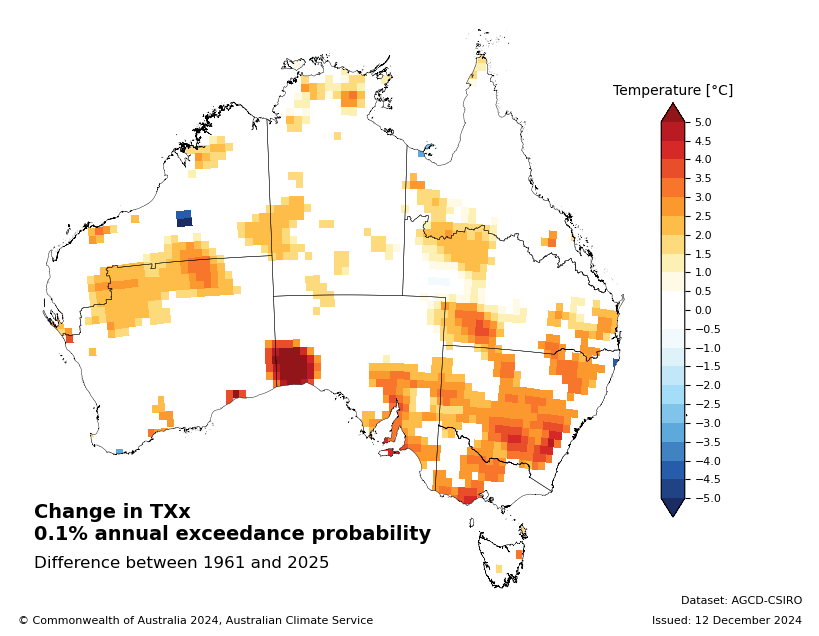

In [25]:
spatial_plots.plot_aep(
    info,
    dparams_ns,
    times,
    aep=aep_list[2],
)

## Probability of breaking the observed record

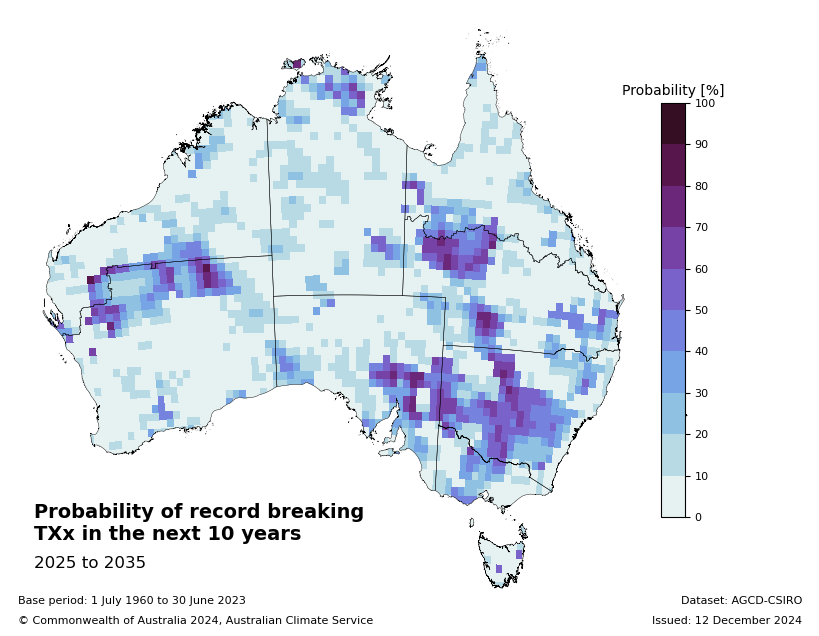

In [26]:
spatial_plots.plot_new_record_probability(
    info,
    obs_ds,
    None,
    dparams_ns,
    covariate_base,
    time_agg,
    ari=10,
)

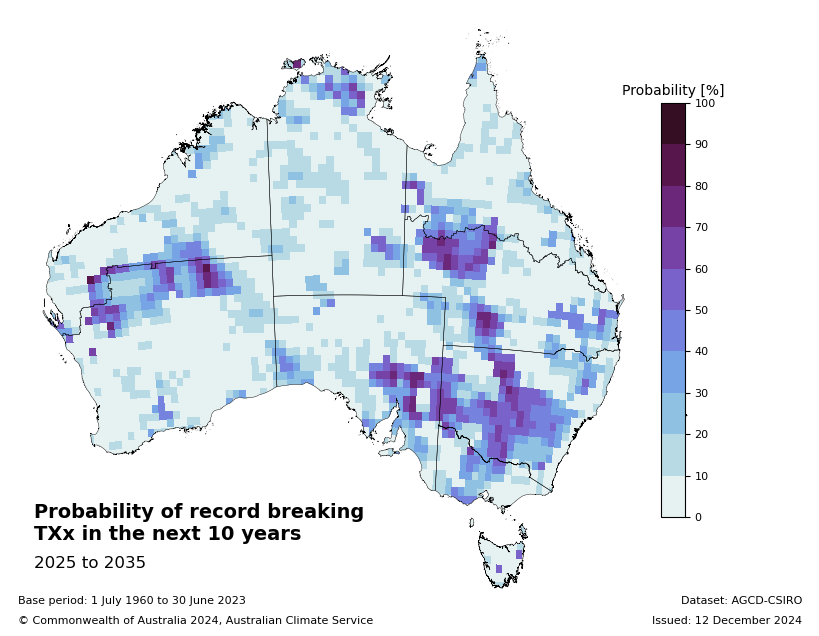

In [27]:
# Repeat for max event removed
info_copy = info.__copy__()  # Copy InfoSet object & update names
info_copy.long_name = f"{info.long_name} (max event removed)"
info_copy.file = info_copy.file.with_name(f"{info.filestem()}_drop_max.nc")

spatial_plots.plot_new_record_probability(
    info_copy,
    obs_ds,
    None,
    dparams_ns,
    covariate_base,
    time_agg,
    ari=10,
)